## In this script the Bag of Words model for text classification is applied 

In [1]:
import csv
import math
import nltk
import spacy
import pandas as pd
import matplotlib.pyplot as plt
nlp = spacy.load("de_core_news_sm")

### Preprocessing 

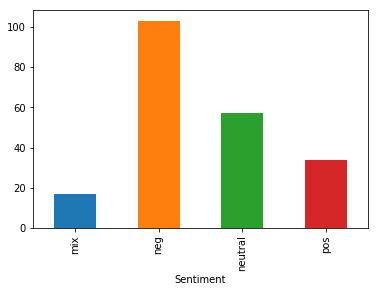

In [2]:
data_all = pd.read_csv("/Users/genecosmo/Desktop/Sentimentanalyse für literarische Texte/Bericht/Dataset_Emilia_Galotti_Final_withMix.csv",
                   sep = ",",
                   usecols = ["Repliken", "Sentiment"],
                   encoding = 'utf-8')
data_all.groupby('Sentiment').Repliken.count().plot.bar(ylim=0)
plt.show()

### Since the Training data for mix is too little, so only the binary tendency for mix is used.

In [3]:
# read the data by using pandas
data_replaced = pd.read_csv("/Users/genecosmo/Desktop/Sentimentanalyse für literarische Texte/Bericht/Dataset_Emilia_Galotti_Final_noMix.csv",
                   sep = ",",
                   usecols = ["Repliken", "Sentiment"],
                   encoding = 'utf-8')

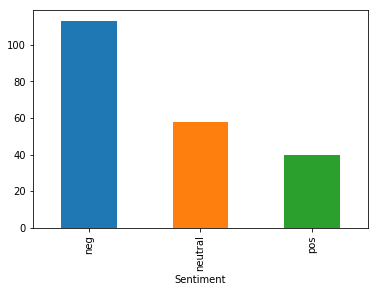

In [4]:
data_replaced.groupby('Sentiment').Repliken.count().plot.bar(ylim=0)
plt.show()

In [5]:
# Add 3 columns to contain respectively the lemmatized, stemmed 
# and LemmaStemmed (first lemmatized and then stemmed) texts

data_replaced["Lemmatized"] = data_replaced['Repliken'].apply(lambda x : " ".join([w.lemma_ for w in nlp(x)]))

### Classification based on Bag of Words (BoW) Model

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # Try different Vectorizers 
from sklearn.pipeline import Pipeline    # Combine multiple procedures together
from sklearn.metrics import classification_report  # Report detailed evaluation info about precision, recall, f-score for different classes
from sklearn.feature_selection import SelectKBest, chi2  # Help select the most useful features

In [7]:
# Initialize the Vectorizer (after multiple tests, it is found that the default settings produce the best results)
vectorizer_Tfidf = TfidfVectorizer(tokenizer = nltk.word_tokenize)
vectorizer_Count = CountVectorizer(tokenizer = nltk.word_tokenize) # using tokenizer from nltk can lead to better results.

In [8]:
# These algorithms are suitable for multiclass classification.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC 
from sklearn.naive_bayes import MultinomialNB

knn = KNeighborsClassifier()
lr = LogisticRegression(multi_class= "ovr")
svc = LinearSVC(multi_class="crammer_singer")
nb = MultinomialNB()

In [11]:
from sklearn import metrics
from sklearn.cross_validation import KFold
kf_5 = KFold(n = 211, n_folds = 5) # Altogether 211 speeches; 5 folds is a common setting for cross-validation procedure.


In [12]:
def tryClassifier(text, labels, pipe, evaluation_tag):
    precisions = 0
    recalls = 0
    f_measures = 0
    acc = 0
    # For each iteration: 1 fold out of 5 folds are used as test set and the other 4 folds as training set.
    # At the end every fold is used as test set once.
    # The average scores are considered as cross-validated (CV) scores.
    
    for (train_index, test_index) in kf_5:  
        X_train, X_test = text[train_index], text[test_index] 
        y_train, y_test = labels[train_index], labels[test_index]
        
        pipe.fit(X_train, y_train)
        tag_pred = pipe.predict(X_test)
        
        #print(metrics.classification_report(y_test, tag_pred)) 
        # The line above can be used if detailed evaluation-info for each train/test set is wanted.

        precisions += metrics.precision_score(y_test, tag_pred, average = "weighted", labels = [evaluation_tag]) 
        recalls += metrics.recall_score(y_test, tag_pred, average = "weighted", labels = [evaluation_tag])
        f_measures += metrics.f1_score(y_test, tag_pred, average = "weighted", labels = [evaluation_tag])
        acc += metrics.accuracy_score(y_test, tag_pred)

    print(evaluation_tag, ": CV_Precion: ", round(precisions/5,4), "CV_Recall:", round(recalls/5,4),"CV_F_measure: ", round(f_measures/5, 4))
    print("CV_accuracy for all classes: ", round(acc/5,4))


### Baseline for different classes: 

In [13]:
# Baseline (f1-score) for these 3 classes are defined and computed as follows: 
print("Baseline_f1_score_pos: ", round(40/211 *2 / (1 + 40/211), 4))      # tag all speeches as "pos"
print("Baseline_f1_score_neutral: ", round(58/211 *2 / (1 + 58/211), 4))  # tag all speeches as "neutral"
print("Baseline_f1_score_neg: ", round(113/211 *2 / (1 + 113/211), 4))    # tag all speeches as "neg"
print("Baseline_accuracy_all_classes", round(113/211, 4))      # tag all speeches with the most frequent tag -- "neg"

Baseline_f1_score_pos:  0.3187
Baseline_f1_score_neutral:  0.4312
Baseline_f1_score_neg:  0.6975
Baseline_accuracy_all_classes 0.5355


### Normalization (According to the result, normalizing the positive words and negations can lead to better performance.)

In [14]:
#Further normalizing negations
nomalized_negation = []
for sp in data_replaced.Repliken:
    wordlist = []
    for w in sp.split():
        # replace all words that contain negated meaning with "negation".
        if w.lower() == "nicht" or w.lower() == "nein" or w.lower() == "kein" or w.lower() == "nie":
            wordlist.append("negation")
        else:
            wordlist.append(w)
    nomalized_negation.append(" ".join(wordlist))
print(nomalized_negation[:6])



['Nach dem Marchese ist geschickt. Und hier, ein Brief von der Gräfin Orsina.', 'Ihr Läufer wartet.', 'Ich will die Antwort senden; wenn es einer bedarf. – Wo ist sie? In der Stadt? oder auf ihrer Villa?', 'Der Maler Conti will die Gnade haben – –', "Klagen, nichts als Klagen! Bittschriften, nichts als Bittschriften! – Die traurigen Geschäfte; und man beneidet uns noch! – Das glaub' ich; wenn wir allen helfen könnten: dann wären wir zu beneiden. – Emilia? Indem er noch eine von den Bittschriften aufschlägt, und nach dem unterschriebnen Namen sieht. Eine Emilia? – Aber eine Emilia Bruneschi – negation Galotti. negation Emilia Galotti! – Was will sie, diese Emilia Bruneschi? Er lieset. Viel gefodert; sehr viel. – Doch sie heißt Emilia. Gewährt! Er unterschreibt und klingelt; worauf ein Kammerdiener hereintritt. Es ist wohl noch keiner von den Räten in dem Vorzimmer?", 'Die Gräfin Orsina.']


### "geschickt" is annotated as "pos", but this word is polysemous, when this word only means "sent" like in the sentence above, then it should just be considered as neutral.

In [15]:
df = pd.DataFrame({"Normalized" : nomalized_negation, "Sentiment" : data_replaced.Sentiment})

In [16]:
df.head(5)

,Normalized,Sentiment
0,"Nach dem Marchese ist geschickt. Und hier, ein...",neutral
1,Ihr Läufer wartet.,neutral
2,Ich will die Antwort senden; wenn es einer bed...,neg
3,Der Maler Conti will die Gnade haben – –,neutral
4,"Klagen, nichts als Klagen! Bittschriften, nich...",neg


In [17]:
X2 = df.Normalized
y2 = df.Sentiment

In [18]:
# The pipeline combines vectorization process (BoW model), feature selection procedure (based on chi-squared stats ) 
# and classifier (which used specific machine learning algorithm) together.

pipeline2 = Pipeline([('vect', vectorizer_Tfidf),
                     ('chi',  SelectKBest(chi2, k=500)),  #"105" this parameter can be understood as 105 words are used as features.
                     ('clf', svc)])

print(pipeline2)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...0,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0))])


In [19]:
tryClassifier(X2, y2, pipeline2, "pos")
print()
tryClassifier(X2, y2, pipeline2, "neutral")
print()
tryClassifier(X2, y2, pipeline2, "neg")


pos : CV_Precion:  0.95 CV_Recall: 0.4112 CV_F_measure:  0.5066
CV_accuracy for all classes:  0.6588

neutral : CV_Precion:  0.625 CV_Recall: 0.4223 CV_F_measure:  0.4975
CV_accuracy for all classes:  0.6588

neg : CV_Precion:  0.6436 CV_Recall: 0.8934 CV_F_measure:  0.7408
CV_accuracy for all classes:  0.6588


### Use all dataset as training data 

In [20]:
import xml.etree.ElementTree as ET

In [21]:
ns = {"tei" : "http://www.tei-c.org/ns/1.0"}
tree = ET.parse("/Users/genecosmo/Desktop/Sentimentanalyse für literarische Texte/Bericht/data.xml")

In [25]:
# Store data of the drama (scene, speaker, speech) into corresponding lists.
akt_auftritt = []
figuren = []
repliken = []

for akt in range(1, 6):
    for auftritt in range(1,13):
        attribut = "/Literatur/M/Lessing, Gotthold Ephraim/Dramen/Emilia Galotti/" + str(akt) +". Akt/" + str(auftritt) + ". Auftritt']"

        Auftritt = tree.findall(str(".//tei:div[2]/..[@n = '"+ attribut), ns)
        for child in Auftritt:  
            speeches = child.findall(".//tei:sp",ns) # Repliken
            for speech_child in speeches:
                speaker_node = speech_child.findall(".//tei:speaker",ns) 
                for speaker in speaker_node:
                    #print("".join(speaker.itertext()))
                    figuren.append("".join(speaker.itertext()))
                line = speech_child.findall(".//tei:l[1]",ns)  
                paragraph = speech_child.findall(".//tei:p[1]",ns) 
                if line != None:
                    for l in line:
                        l_text = "".join(l.itertext())
                        repliken.append(l_text)
                if paragraph != None:
                    for p in paragraph:
                        p_text = "".join(p.itertext())
                        repliken.append(p_text)
                akt_auftritt.append(str(akt) + "_Akt_" + str(auftritt) + "_Auftritt")
                

In [26]:
df_all = pd.DataFrame({"Position" : akt_auftritt, "Speaker" : figuren, "Speeches" : repliken})
df_all.head(5)

,Position,Speaker,Speeches
0,1_Akt_1_Auftritt,DER PRINZ,"Klagen, nichts als Klagen! Bittschriften, nic..."
1,1_Akt_1_Auftritt,DER KAMMERDIENER.,Nein.
2,1_Akt_1_Auftritt,DER PRINZ.,Ich habe zu früh Tag gemacht. – Der Morgen is...
3,1_Akt_1_Auftritt,DER KAMMERDIENER,"Nach dem Marchese ist geschickt. Und hier, ei..."
4,1_Akt_1_Auftritt,DER PRINZ.,Der Orsina? Legt ihn hin.


In [27]:
df_all.to_csv("All_Speakers_Speeches.csv",sep = ",", encoding = "utf-8", index = False)

In [28]:
#normalizing negations
nomalized_negation_All = []
for sp in df_all.Speeches:
    wordlist = []
    for w in sp.split():
        # replace all words that contain negated meaning with "negation".
        if w.lower() == "nicht" or w.lower() == "nein" or w.lower() == "kein" or w.lower() == "nie":
            wordlist.append("negation")
        else:
            wordlist.append(w)
    nomalized_negation_All.append(" ".join(wordlist))

df_all["Normalized"] = nomalized_negation_All

In [29]:
classifier = pipeline2.fit(X2, y2)
tag_pred = classifier.predict(df_all.Normalized)

In [30]:
tags = tag_pred.tolist()

In [31]:
# Classification results and the information about the speakers, speeches 
# are be combined together with the format (akt_auftritt, speaker, speech, tag)
results = list(zip(akt_auftritt, figuren, repliken, tags))


In [32]:
print(results[:3])

[('1_Akt_1_Auftritt', 'DER PRINZ', " Klagen, nichts als Klagen! Bittschriften, nichts als Bittschriften! – Die traurigen Geschäfte; und man beneidet uns noch! – Das glaub' ich; wenn wir allen helfen könnten: dann wären wir zu beneiden. – Emilia? Indem er noch eine von den Bittschriften aufschlägt, und nach dem unterschriebnen Namen sieht. Eine Emilia? – Aber eine Emilia Bruneschi – nicht Galotti. Nicht Emilia Galotti! – Was will sie, diese Emilia Bruneschi? Er lieset. Viel gefodert; sehr viel. – Doch sie heißt Emilia. Gewährt! Er unterschreibt und klingelt; worauf ein Kammerdiener hereintritt. Es ist wohl noch keiner von den Räten in dem Vorzimmer?", 'neg'), ('1_Akt_1_Auftritt', 'DER KAMMERDIENER.', ' Nein.', 'pos'), ('1_Akt_1_Auftritt', 'DER PRINZ.', " Ich habe zu früh Tag gemacht. – Der Morgen ist so schön. Ich will ausfahren. Marchese Marinelli soll mich begleiten. Laßt ihn rufen. Der Kammerdiener geht ab. – Ich kann doch nicht mehr arbeiten. – Ich war so ruhig, bild' ich mir ein, s

In [33]:
neutral_Marinelli=[]
for result in results:
    if "marinelli" in result[1].lower() and result[3]=="neutral":
        neutral_Marinelli.append(result[0])
fdist_Marinelli=nltk.FreqDist(neutral_Marinelli)
print(fdist_Marinelli.most_common(10))
# sort by value
sortedDist = [(k,v) for (k,v) in sorted(fdist_Marinelli.items(), key=lambda item: item[1], reverse=True)]
print(len(sortedDist))
print(len(neutral_Marinelli)-16-9-9-8-6-6-5-4-3-3) # the number of the rest neutral speeches

[('1_Akt_6_Auftritt', 16), ('2_Akt_10_Auftritt', 9), ('4_Akt_5_Auftritt', 9), ('3_Akt_1_Auftritt', 8), ('4_Akt_1_Auftritt', 6), ('4_Akt_3_Auftritt', 6), ('5_Akt_5_Auftritt', 5), ('5_Akt_3_Auftritt', 4), ('3_Akt_2_Auftritt', 3), ('3_Akt_4_Auftritt', 3)]
15
7


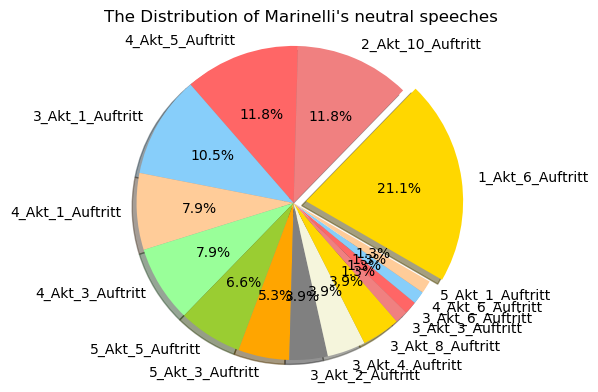

In [34]:
actAuftritt = [item[0] for item in sortedDist]
numNeutral = [item[1] for item in sortedDist]
colors = ['gold', 'lightcoral', '#ff6666', 'lightskyblue', '#ffcc99', '#99ff99', 'yellowgreen','orange', 'grey', 'beige']
explode=[0.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
# Plot
plt.figure(dpi=100)
plt.pie(numNeutral, explode = explode, labels=actAuftritt, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=330)
plt.title("The Distribution of Marinelli's neutral speeches")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [35]:
# Print all neutral speeches of Marinelli in 1. Akt 6. Auftritt.
for result in results:
    if "marinelli" in result[1].lower() and result[3]=="neutral" and result[0] == "1_Akt_6_Auftritt":
        print(result[2])

 Gnädiger Herr, Sie werden verzeihen. – Ich war mir eines so frühen Befehls nicht gewärtig.
 Nichts von Belang, das ich wüßte. – Die Gräfin Orsina ist gestern zur Stadt gekommen.
 Bin ich, leider, nicht ihr Vertrauter? – Aber, wenn ich es wieder von einer Dame werde, der es einkömmt, Sie in gutem Ernste zu lieben, Prinz: so – –
 Wenn es nur das wäre: so müßte freilich Orsina sich in ihr Schicksal eben so wohl zu finden wissen, als der Prinz in seines.
 So gut, wie gar nichts. – Denn daß die Verbindung des Grafen Appiani heute vollzogen wird, – ist nicht viel mehr, als gar nichts.
 Es ist eine gewisse Emilia Galotti.
 Emilia Galotti.
 Zuverlässig, gnädiger Herr.
 Eben die.
 Eben die.
 Eben die.
 Eben die.
 Aber was ist Ihnen, gnädiger Herr?
 Retten? ist da viel zu retten? – Was Sie versäumt haben, gnädiger Herr, der Emilia Galotti zu bekennen, das bekennen Sie nun der Gräfin Appiani. Waren, die man aus der ersten Hand nicht haben kann, kauft man aus der zweiten; – und solche Waren nicht

In [36]:
# Print all neutral speeches of Marinelli in 2_Akt_10_Auftritt.
for result in results:
    if "marinelli" in result[1].lower() and result[3]=="neutral" and result[0] == "2_Akt_10_Auftritt":
        print(result[2])

 Ich komme von des Prinzen Durchlaucht.
 Nun so kommen Sie.
 Nach Dosalo, zu dem Prinzen. – Es liegt schon alles fertig; und Sie müssen noch heut' abreisen.
 Lieber noch in dieser nämlichen Stunde, als in der folgenden. Die Sache ist von der äußersten Eil.
 Wie?
 Sie scherzen, Herr Graf.
 Größer oder kleiner: Herr ist Herr.
 Wollen Sie ihn nicht zugleich wissen lassen, mit wem?
 Der Tochter aus diesem Hause?


In [37]:
# Print all neutral speeches of Marinelli in 2_Akt_10_Auftritt.
for result in results:
    if "marinelli" in result[1].lower() and result[3]=="neutral" and result[0] == "4_Akt_5_Auftritt":
        print(result[2])

 Leider nicht bloß geträumet! – Aber die andern, die mit dem Grafen waren, haben sich glücklich hierher nach dem Schlosse gerettet: seine Braut nämlich, und die Mutter der Braut, mit welchen er nach Sabionetta zu seiner feierlichen Verbindung fahren wollte.
 Dem Prinzen geht ihr Unfall ungemein nahe.
 Es ist Emilia Galotti.
 Wie so?
 Sollte ich ihr schon zu viel gesagt haben?
 Wie das?
 Wie kann ich das?
 Woran?
 Wie kann Ihnen so eine Abscheuligkeit in den Mund, in die Gedanken kommen?


### Plot the emotional trajectories to show interpersonal relationships
#### Extract the sentiment for one character towards another one when they talking to each other.

In [38]:
# If the speech of one character (character2) come directly 
# after another character's (character1) speech, 
# this speech is considered as the character2's sentiment towards character1.
# All strings passed as parameters should be in lowercase.
# character1_offstage should be a list of name-variants for character1.

def sentiment_development(character1, character2):

    scenes = []
    scores_related = []

    for act in range (1, 6):
        for auftritt in range(1, 12):
            tmp = str(act) + "_Akt_" + str(auftritt) + "_Auftritt"
            scores = []
            count = 0
            scene = ""
            for index in range(835-1):      # Altogether 835 speeches
                
                if akt_auftritt[index] == tmp and akt_auftritt[index+1] == tmp: # Only if the akt_auftritt exists and two speeches are in the same scene
                    scene = str(act) + "_" + str(auftritt)
                        
                    # When chara1 and chara2 are in a successive conversation      
                    if character1 in figuren[index].lower() and character2 in figuren[index+1].lower():
                        #print(scene)
                        count += 1
                        if tags[index+1] == "pos":
                            scores.append(1)
                            #print(repliken[index+1])
                        if tags[index+1] == "neg":
                            scores.append(-1)
                            #print(repliken[index+1])
                        if tags[index+1] == "neutral":
                            scores.append(0)
                                
            if scene != "" and count > 1: ###
                scenes.append(scene)
                scores_related.append(scores)
                

    return (scenes, scores_related)

In [39]:
def fine_grained(chara1, chara2):
    result = sentiment_development(chara1, chara2)
    fine_grained_scores = []
    fine_grained_scenes = []
    for index in range(len(result[0])):
        scores = result[1][index]
        
        if len(scores) <= 5:
            fine_grained_scores.append(round(sum(scores)/len(scores), 4))
            fine_grained_scenes.append(result[0][index])
        else:
            folds = len(scores)//3     # every 3 speeches are considered as one unit
            if len(scores)%3 > 0:      # if the total number of scores divided by 3 has remainer
                for fold in range(folds-1):
                    new_score = round(sum(scores[fold*3 : (fold+1)*3])/3, 4)
                    fine_grained_scores.append(new_score)
                    fine_grained_scenes.append(result[0][index] + "_" + str(fold+1))
                last_score = round(sum(scores[(folds-1) * 3 :])/len(scores[(folds-1) * 3 :]), 4)
                fine_grained_scores.append(last_score)
                fine_grained_scenes.append(result[0][index] + "_" + str(folds))
            if len(scores)%3 == 0:
                for fold in range(folds):
                    new_score = round(sum(scores[fold*3 : (fold+1)*3])/3, 4)
                    fine_grained_scores.append(new_score)
                    fine_grained_scenes.append(result[0][index] + "_" + str(fold+1))
    return (fine_grained_scores,fine_grained_scenes)

In [40]:
def plot(chara1, chara2):
    char2_to_char1 = fine_grained(chara1, chara2)[0]
    scenes21 = fine_grained(chara1, chara2)[1]
    char1_to_char2 = fine_grained(chara2, chara1)[0]
    scenes12 = fine_grained(chara2, chara1)[1]
    if len(scenes12) == len(scenes21):
        axis_x = scenes12
        axis_y12 = char1_to_char2
        axis_y21 = char2_to_char1
        plt.figure(figsize=(9,4), dpi=70)
        plt.plot(axis_x, axis_y12, 'o-', label = chara1 +" to " + chara2)
        plt.plot(axis_x, axis_y21, 'o-', label = chara2 +" to " + chara1)
        plt.xlabel("Scenes")
        plt.ylabel("Polarity_normalized")
        plt.title("Progress Chart - Character-to-Character")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    

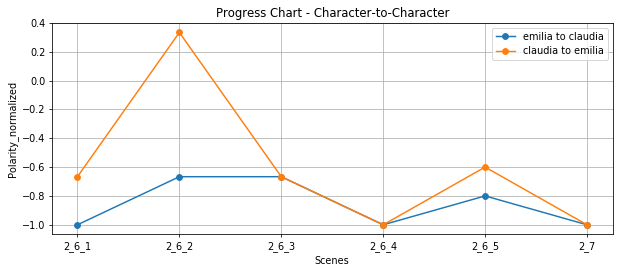

In [41]:
plot('emilia','claudia')

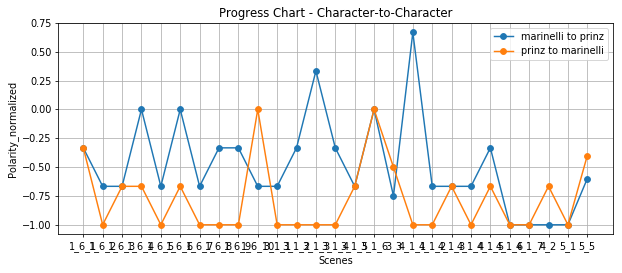

In [42]:
plot('marinelli','prinz')

In [43]:
def percentage_senti(character, senti):
    num_senti = 0
    num_all = 0
    for result in results:
        if character in result[1].lower(): # check if the speaker is the given character
            num_all += 1 # count all speeches that belong to the given character
            if result[3].lower() == senti:
                num_senti += 1  # count all speeches that belong to the given character and have the given sentiment
            
    percentage = round(num_senti/num_all, 4) 
    return percentage

  Characters  Percentages(neutral)
0      prinz                0.1401
1    appiani                0.1667
2  marinelli                0.3439
3    odoardo                0.0648
4    claudia                0.1918
5     orsina                0.0781
6     emilia                0.0938


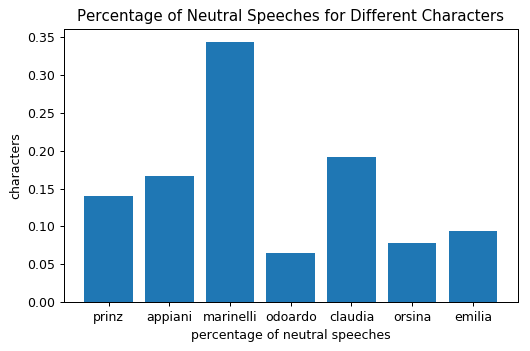

In [44]:
characters = ['prinz','appiani','marinelli','odoardo', 'claudia','orsina', 'emilia']
percentages = []
for char in characters:
    percentages.append(percentage_senti(char, 'neutral'))

plt.figure(figsize=(6,4), dpi=90)
plt.bar(characters, percentages)
plt.title("Percentage of Neutral Speeches for Different Characters")
plt.xlabel("percentage of neutral speeches")
plt.ylabel("characters")

neutral_percentage = pd.DataFrame({"Characters" : characters, "Percentages(neutral)" : percentages})
print(neutral_percentage.head(7))
plt.tight_layout()
plt.show()

In [38]:
num_senti = 0
num_all = 0
for result in results:
    num_all += 1
    if result[3].lower() == 'neutral':
        num_senti += 1  # count all speeches that belong to the given character and have the given sentiment
            
percentage = round(num_senti/num_all, 4) 
print(percentage)

0.2012
